**LIBRARIES**

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms
import cv2
import math

from collections import Counter
from PIL import Image
import PIL

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as fun

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()
from nltk.tokenize import word_tokenize

import match
import pickle
import gc
import random

**DATA Preprocessing** 

In [29]:
data = pd.read_csv("captions.txt", sep=',')
display(data)

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                                           caption  
0         A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                            A girl going into a wooden building .  
2                                 A little girl climbing into a wooden playhouse .  
3                             A little girl climbing the stairs to her playhouse .  
4                        A little girl in a pink dress going into a wooden cabin .  
...                                                                            ...  
40450                                     A man in a pink shirt climbs a rock face  
40451                                     A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock face covered in assist handles .  
40453                                              A rock climber in a red shirt .  
40454                           A rock climber practices on a rock climbing wall .  

[40455 rows x 2 columns]

**Tokenization**

In [30]:
#Removes Single Char
def remove_single_char(caption_list):
    list = []
    for word in caption_list:
        if len(word)>1:
            list.append(word)
    return list

In [31]:
#Make an array of words out of caption and then remove useless single char words

data['caption'] = data['caption'].apply(lambda caption :word_tokenize(caption))

data['caption'] = data['caption'].apply(lambda word : remove_single_char(word))

#We need to make sure size of all the captions arrays is same so we add <cell> to cover up
lengths = []
lengths = data['caption'].apply(lambda caption : len(caption))

max_length = lengths.max()

data['caption'] = data['caption'].apply(lambda caption : ['<start>'] + caption + ['<cell>']*(max_length-len(caption)) + ['<end>'])

#For non truncated dataframe to appear
pd.set_option('display.max_colwidth', None)
display(data)

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                                                                                                                                                                                                                                                 caption  
0                                        [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
1          [<start>, girl, going, into, wooden, building, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
2      [<start>, little, girl, climbing, into, wooden, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
3              [<start>, little, girl, climbing, the, stairs, to, her, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
4                    [<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
...                                                                                                                                                                                                                                                                                  ...  
40450                 [<start>, man, in, pink, shirt, climbs, rock, face, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
40451                      [<start>, man, is, rock, climbing, high, in, the, air, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
40452                   [<start>, person, in, red, shirt, climbing, up, rock, face, covered, in, assist, handles, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
40453            [<start>, rock, climber, in, red, shirt, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  
40454       [<start>, rock, climber, practices, on, rock, climbing, wall, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]  

[40455 rows x 2 columns]

**Vocab and Dictionary**

In [32]:
#Extracting words 
words = data['caption'].apply(lambda word : " ".join(word)).str.cat(sep = ' ').split(' ')
display(words)

['<start>',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<end>',
 '<start>',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<end>',
 '<start>',
 'little',
 'girl',
 'climbing',
 'into',
 'wooden',
 'playhouse',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',
 '<cell>',


**Vocab**

In [33]:
#Arranging the words in order of their frequency
word_dict = sorted(Counter(words), key=Counter(words).get, reverse=True)

dict_size = len(word_dict)
vocab_threshold = 5

print(len(word_dict))
print(vocab_threshold)
display(word_dict)

9596
5


['<cell>',
 '<start>',
 '<end>',
 'in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'Two',
 'white',
 'black',
 'are',
 'boy',
 'woman',
 'girl',
 'to',
 'The',
 'wearing',
 'at',
 'water',
 'red',
 'brown',
 'people',
 'young',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'an',
 'down',
 'shirt',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'jumping',
 'over',
 'person',
 'front',
 'sitting',
 'holding',
 'field',
 'two',
 'up',
 'by',
 'green',
 'small',
 'yellow',
 'large',
 'her',
 'group',
 'walking',
 'Three',
 'into',
 'air',
 'beach',
 'men',
 'near',
 'one',
 'children',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'out',
 'rock',
 'next',
 'play',
 'off',
 'looking',
 'pink',
 'orange',
 'player',
 'their',
 'pool',
 'camera',
 'hat',
 'jacket',
 'around',
 'boys',
 'behind',
 'women',
 'background',
 'toy',
 '

In [34]:
#Encoding the words with index in dictionary made above
data['sequence'] = data['caption'].apply(lambda caption : [word_dict.index(word) for word in caption])

display(data)

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                                                                                                                                                                                                                                                 caption  \
0                                        [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
1          [<start>, girl, going, into, wooden, building, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
2      [<start>, little, girl, climbing, into, wooden, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
3              [<start>, little, girl, climbing, the, stairs, to, her, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
4                    [<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
...                                                                                                                                                                                                                                                                                  ...   
40450                 [<start>, man, in, pink, shirt, climbs, rock, face, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40451                      [<start>, man, is, rock, climbing, high, in, the, air, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40452                   [<start>, person, in, red, shirt, climbing, up, rock, face, covered, in, assist, handles, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40453            [<start>, rock, climber, in, red, shirt, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40454       [<start>, rock, climber, practices, on, rock, climbing, wall, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   

                                                                                                                       sequence  
0      [1, 43, 3, 90, 174, 6, 120, 52, 409, 11, 405, 3,

In [35]:
data = data.sort_values(by = 'image')

**ResNet18 Pretrained Model**

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Extracting Features from Images**

In [37]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

def get_image_tensor(index, preprocess, data):
    image_name = data.iloc[index]['image']
    img_loc = 'Images/'+str(image_name)
    img = Image.open(img_loc).convert('RGB')
    tensor_image = preprocess(img).unsqueeze(0)

    return tensor_image

**Encoder CNN**

In [38]:
class Encoder_CNN(nn.Module):
    def __init__(self, embed_size):
        super(Encoder_CNN, self).__init__()
        resnet50 = torchvision.models.resnet50(pretrained=True)
        resnet50.eval()
        # for parameters in resnet50.parameters():
        #     parameters.requires_grad_(False)
        modules = list(resnet50.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet50.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, image):
        features = self.model(image)
        features = features.view(features.size(0), -1)
        features = self.dropout(self.relu(self.embed(features)))
        return features

**Embedded Vectors**

In [ ]:
encoder = Encoder_CNN(256)
encoder.eval()

embedded_vectors = []

for i, row in tqdm(data.iterrows(), total=len(data), desc="Processing Images"):
    image_tensor = get_image_tensor(i, preprocess, data)
    image_tensor = image_tensor.to(device)

    print(f"Initial tensor shape: {image_tensor.shape}")

    with torch.no_grad():
        for name, module in encoder.model.named_children():
            image_tensor = module(image_tensor)
            print(f"After layer {name}: {image_tensor.shape}")

    
        output = image_tensor.view(image_tensor.size(0), -1)
        print(f"Output tensor shape: {output.shape}")
        
        embed_vector = encoder.embed(output)
        embedded_vectors.append(embed_vector.cpu().numpy()) 

data['embedded'] = embedded_vectors
print(data)

embedded_data = open("Embedded_Images_data.pkl", "wb")
pickle.dump(data, embedded_data)
embedded_data.close()

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing Images:   0%|          | 0/40455 [00:00<?, ?it/s]

Initial tensor shape: torch.Size([1, 3, 224, 224])
After layer 0: torch.Size([1, 64, 112, 112])
After layer 1: torch.Size([1, 64, 112, 112])
After layer 2: torch.Size([1, 64, 112, 112])
After layer 3: torch.Size([1, 64, 56, 56])
After layer 4: torch.Size([1, 256, 56, 56])
After layer 5: torch.Size([1, 512, 28, 28])
After layer 6: torch.Size([1, 1024, 14, 14])
After layer 7: torch.Size([1, 2048, 7, 7])
After layer 8: torch.Size([1, 2048, 1, 1])
Output tensor shape: torch.Size([1, 2048])
Initial tensor shape: torch.Size([1, 3, 224, 224])
After layer 0: torch.Size([1, 64, 112, 112])
After layer 1: torch.Size([1, 64, 112, 112])
After layer 2: torch.Size([1, 64, 112, 112])
After layer 3: torch.Size([1, 64, 56, 56])
After layer 4: torch.Size([1, 256, 56, 56])
After layer 5: torch.Size([1, 512, 28, 28])
After layer 6: torch.Size([1, 1024, 14, 14])
After layer 7: torch.Size([1, 2048, 7, 7])
After layer 8: torch.Size([1, 2048, 1, 1])
Output tensor shape: torch.Size([1, 2048])
Initial tensor sha

**DataLoaders**

In [39]:
#Training and Validation Data
#Same images but different captions

embed_data = pd.read_pickle('Embedded_Images_data.pkl')
train, validation = train_test_split(embed_data,test_size=0.1,train_size=0.9)

display(embed_data)

print(len(train), train['image'].nunique())

words = train['caption'].apply(lambda word : " ".join(word)).str.cat(sep = ' ').split(' ')
word_dict_train = sorted(Counter(words), key=Counter(words).get, reverse=True)
vocab_size_train = len(word_dict_train)

print(len(validation), validation['image'].nunique())

train_file_features = open("Image_Features_Embed_ResNet_Train.pkl", "wb")
pickle.dump(train, train_file_features)
train_file_features.close()

valid_file_features = open("Image_Features_Embed_ResNet_Valid.pkl", "wb")
pickle.dump(validation, valid_file_features)
valid_file_features.close()


image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                                                                                                                                                                                                                                                 caption  \
0                                        [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
1          [<start>, girl, going, into, wooden, building, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
2      [<start>, little, girl, climbing, into, wooden, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
3              [<start>, little, girl, climbing, the, stairs, to, her, playhouse, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
4                    [<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
...                                                                                                                                                                                                                                                                                  ...   
40452                   [<start>, person, in, red, shirt, climbing, up, rock, face, covered, in, assist, handles, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40453            [<start>, rock, climber, in, red, shirt, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40450                 [<start>, man, in, pink, shirt, climbs, rock, face, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40451                      [<start>, man, is, rock, climbing, high, in, the, air, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   
40454       [<start>, rock, climber, practices, on, rock, climbing, wall, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <cell>, <end>]   

                                                                                                                       sequence  \
0      [1, 43, 3, 90, 174, 6, 120, 52, 409, 11, 405, 3

36409 8091
4046 3321


In [40]:
def loader_dataset(pickle_file):
    data = pd.read_pickle(pickle_file)
    dataset = pd.DataFrame(columns = ['sequence', 'target', 'image'])
    
    for i, row in data.iterrows():
        sequence = torch.tensor(row['sequence'])
        target = torch.tensor(row['sequence'][1:]+[0])
        image_name = row['image']
        
        image_tensor = torch.tensor(row['embedded'], dtype=torch.float32)
        image_tensor_view = image_tensor

        dataset = dataset._append({'sequence' : sequence, 'target' : target, 'image' : image_tensor_view},
        ignore_index = True)

    display(dataset)
    return dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.dataframe.loc[idx, 'sequence'], self.dataframe.loc[idx, 'target'], self.dataframe.loc[idx, 'image']

In [44]:
train_dataset = loader_dataset('Image_Features_Embed_ResNet_Train.pkl')
valid_dataset = loader_dataset('Image_Features_Embed_ResNet_Valid.pkl')

train_dataloader = DataLoader(CustomDataset(train_dataset), batch_size=32, shuffle=True)
valid_dataloader = DataLoader(CustomDataset(valid_dataset), batch_size=32, shuffle=True)

sequence  \
0        [tensor(1), tensor(12), tensor(101), tensor(1097), tensor(36), tensor(164), tensor(3), tensor(47), tensor(11), tensor(46), tensor(454), tensor(5), tensor(163), tensor(3), tensor(47), tensor(11), tensor(180), tensor(9), tensor(71), tensor(46), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
1              [tensor(1), tensor(142), tensor(92), tensor(370), tensor(367), tensor(19), tensor(4790), tensor(4), tensor(39), tensor(3), tensor(142), tensor(806), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
2      [tensor(1), tensor(851), tensor(15), tensor(77), tensor(476), tensor(3), tensor(35), tensor(1546), tensor(137), tensor(4), tensor(517), tensor(11), tensor(5378), tensor(7), tensor(4), tensor(4057), tensor(4058), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
3                    [tensor(1), tensor(10), tensor(21), tensor(14), tensor(7), tensor(13), tensor(37), tensor(44), tensor(5), tensor(8), tensor(152), tensor(159), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
4                    [tensor(1), tensor(20), tensor(27), tensor(10), tensor(6), tensor(48), tensor(5), tensor(427), tensor(587), tensor(539), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
36404               [tensor(1), tensor(254), tensor(26), tensor(15), tensor(48), tensor(98), tensor(408), tensor(22), tensor(304), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
36405                  [tensor(1), tensor(46), tensor(6), tensor(49), tensor(51), tensor(2160), tensor(682), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
36406                  [tensor(1), tensor(61), tensor(30), tensor(87), tensor(9), tensor(179), tensor(3), tensor(143), tensor(50), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
36407              [tensor(1), tensor(10), tensor(78), tensor(5), tensor(442), tensor(73), tensor(9), tensor(565), tensor(7), tensor(1966), tensor(3), tensor(4), tensor(102), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), 

sequence  \
0                  [tensor(1), tensor(16), tensor(7), tensor(10), tensor(107), tensor(79), tensor(945), tensor(1974), tensor(38), tensor(3), tensor(128), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
1             [tensor(1), tensor(576), tensor(2059), tensor(7), tensor(60), tensor(124), tensor(128), tensor(71), tensor(1477), tensor(7), tensor(129), tensor(3), tensor(102), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
2                [tensor(1), tensor(7157), tensor(54), tensor(141), tensor(5), tensor(104), tensor(156), tensor(363), tensor(23), tensor(5), tensor(4), tensor(471), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
3                   [tensor(1), tensor(10), tensor(3), tensor(14), tensor(96), tensor(38), tensor(3), tensor(47), tensor(11), tensor(283), tensor(109), tensor(7), tensor(221), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
4     [tensor(1), tensor(2185), tensor(3161), tensor(2157), tensor(6), tensor(4358), tensor(72), tensor(410), tensor(44), tensor(79), tensor(248), tensor(415), tensor(19), tensor(167), tensor(179), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
...                                                                                                                                                                                                                                                                                                                                                                                                                ...   
4041                        [tensor(1), tensor(14), tensor(8), tensor(6), tensor(912), tensor(3), tensor(4), tensor(42), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
4042                  [tensor(1), tensor(18), tensor(70), tensor(76), tensor(35), tensor(91), tensor(540), tensor(62), tensor(180), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
4043       [tensor(1), tensor(17), tensor(9), tensor(858), tensor(306), tensor(29), tensor(329), tensor(7), tensor(1110), tensor(105), tensor(5), tensor(356), tensor(1010), tensor(11), tensor(366), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(2)]   
4044                   [tensor(1), tensor(121), tensor(373), tensor(264), tensor(9), tensor(43), tensor(5), tensor(165), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), t

**Decoder Transformer**

In [41]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=(max_length+2)):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [42]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()
        self.n_head = n_head

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        # display(decoder_inp)
        encoded_image = encoded_image.permute(1,0,2)

        decoder_inp = torch.clamp(decoder_inp, 0, self.embedding.num_embeddings - 1)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        decoder_inp_embed = self.embedding(decoder_inp)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        
        
        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

**Training Model**

In [47]:
EPOCH = 30

ictModel = ImageCaptionModel(16, 4, vocab_size_train, 256).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [49]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()
    train_pbar = tqdm(train_dataloader, desc='Training', unit='batch')
    ### Train Loop
    for caption_seq, target_seq, image_embed in train_pbar:

        optimizer.zero_grad()

        image_embed = image_embed
        caption_seq = caption_seq
        target_seq = target_seq

        target_seq = torch.clamp(target_seq, 0, vocab_size_train - 1)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        valid_pbar = tqdm(valid_dataloader, desc='Validating', unit='batch')
        for caption_seq, target_seq, image_embed in valid_pbar:

            image_embed = image_embed.to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            target_seq = torch.clamp(target_seq, 0, vocab_size_train - 1)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, 'ImageCaptioing_Model')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

Model_ICT = open("ImageCaptioning_Model.pkl", "wb")
pickle.dump(ictModel, Model_ICT)
Model_ICT.close()


  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  0  Training Loss ->  5.929112911224365 Eval Loss ->  5.343247413635254
Writing Model at epoch  0


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  1  Training Loss ->  5.172939300537109 Eval Loss ->  5.009350776672363
Writing Model at epoch  1


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  2  Training Loss ->  4.937122821807861 Eval Loss ->  4.804827690124512
Writing Model at epoch  2


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  3  Training Loss ->  4.75165319442749 Eval Loss ->  4.597782611846924
Writing Model at epoch  3


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  4  Training Loss ->  4.574219703674316 Eval Loss ->  4.431055068969727
Writing Model at epoch  4


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  5  Training Loss ->  4.425890922546387 Eval Loss ->  4.309811115264893
Writing Model at epoch  5


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  6  Training Loss ->  4.307894229888916 Eval Loss ->  4.209988117218018
Writing Model at epoch  6


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  7  Training Loss ->  4.207068920135498 Eval Loss ->  4.126709461212158
Writing Model at epoch  7


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  8  Training Loss ->  4.122218608856201 Eval Loss ->  4.061115264892578
Writing Model at epoch  8


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  9  Training Loss ->  4.049210548400879 Eval Loss ->  3.9939262866973877
Writing Model at epoch  9


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  10  Training Loss ->  3.9844512939453125 Eval Loss ->  3.9382100105285645
Writing Model at epoch  10


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  11  Training Loss ->  3.925638198852539 Eval Loss ->  3.8900699615478516
Writing Model at epoch  11


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  12  Training Loss ->  3.8736040592193604 Eval Loss ->  3.8481976985931396
Writing Model at epoch  12


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  13  Training Loss ->  3.82539439201355 Eval Loss ->  3.8108651638031006
Writing Model at epoch  13


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  14  Training Loss ->  3.780243158340454 Eval Loss ->  3.774228811264038
Writing Model at epoch  14


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  15  Training Loss ->  3.7380995750427246 Eval Loss ->  3.74110746383667
Writing Model at epoch  15


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  16  Training Loss ->  3.6994075775146484 Eval Loss ->  3.7101871967315674
Writing Model at epoch  16


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  17  Training Loss ->  3.6640963554382324 Eval Loss ->  3.686458110809326
Writing Model at epoch  17


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  18  Training Loss ->  3.630553960800171 Eval Loss ->  3.662682056427002
Writing Model at epoch  18


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  19  Training Loss ->  3.5970096588134766 Eval Loss ->  3.6303012371063232
Writing Model at epoch  19


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  20  Training Loss ->  3.5669054985046387 Eval Loss ->  3.6058223247528076
Writing Model at epoch  20


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  21  Training Loss ->  3.538541793823242 Eval Loss ->  3.5814175605773926
Writing Model at epoch  21


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  22  Training Loss ->  3.510761260986328 Eval Loss ->  3.56659197807312
Writing Model at epoch  22


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  23  Training Loss ->  3.484931707382202 Eval Loss ->  3.539510488510132
Writing Model at epoch  23


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  24  Training Loss ->  3.4601645469665527 Eval Loss ->  3.519946336746216
Writing Model at epoch  24


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  25  Training Loss ->  3.4359641075134277 Eval Loss ->  3.500014066696167
Writing Model at epoch  25


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  26  Training Loss ->  3.4123921394348145 Eval Loss ->  3.4860403537750244
Writing Model at epoch  26


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  27  Training Loss ->  3.389772891998291 Eval Loss ->  3.467179298400879
Writing Model at epoch  27


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  28  Training Loss ->  3.369004487991333 Eval Loss ->  3.4516282081604004
Writing Model at epoch  28


Training:   0%|          | 0/1138 [00:00<?, ?batch/s]

Validating:   0%|          | 0/127 [00:00<?, ?batch/s]

Epoch ->  29  Training Loss ->  3.3467423915863037 Eval Loss ->  3.430915117263794
Writing Model at epoch  29


**Caption Generation**

In [43]:
model = pd.read_pickle('ImageCaptioning_Model.pkl')
start_token = 2
end_token = 3
cell_token = 1
max_seq_len = 34

In [70]:
valid_img_embed = pd.read_pickle('Image_Features_Embed_ResNet_Valid.pkl')

In [67]:
def generate_caption(K, image_path): 

    model.eval() 
    encoder = Encoder_CNN(256)
    encoder.eval()

    image = Image.open('Images/' + image_path).convert("RGB")
    plt.imshow(image)
    valid_img_df = validation[validation['image']==image_path]
    
    print("Actual Caption : ")
    actual_caption_list = valid_img_df['caption'].tolist()
    filtered_caption_list = [word for word in actual_caption_list[0] if word not in ['<start>', '<end>', '<cell>']]
    actual_caption = " ".join(filtered_caption_list)
    print(actual_caption)

    valid_img_embed_dif = valid_img_embed[valid_img_embed['image'] == image_path]
        
    img_embed = valid_img_embed_dif['embedded'].tolist()

    img_embed = torch.tensor(img_embed).to(device)


    input_seq = [cell_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            img_embed_dense = img_embed.to_dense()

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            index_to_word = {index: word for index, word in enumerate(word_dict)}
            next_word = index_to_word[next_word_index]

            if eval_iter + 1 < max_seq_len:
                input_seq[:, eval_iter + 1] = next_word_index

            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    
    print("\n")
    print("Predicted caption : ")

    filtered_caption_list = [word for word in predicted_sentence if word not in ['<start>', '<end>', '<cell>']]
    print(" ".join(filtered_caption_list))

Actual Caption : 
man is riding red racing motorcycle


Predicted caption : 
man in red and white helmet is riding motorcycle


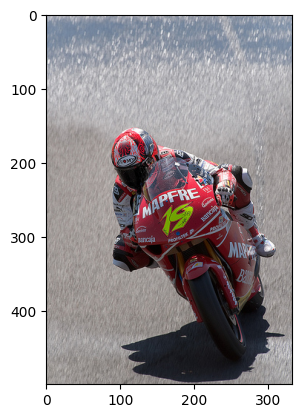

In [68]:
random_row = validation.sample()
random_image = random_row.iloc[0]['image']

generate_caption(1, random_image)